**Transferência de aprendizagem e fine tunin**

**Transferência de aprendizagem**

Transferir o conhecimento de uma rede para outra para que essa outra realize uma atividade similar a rede que teve sua aprendizagem transferida. **Transferir o conhecimento de uma rede para outro**. Imagenet

Já existem redes pré-treinadas para realizar a classificação com uma imagem. O treino já foi realizado, pode-se utilizar os pesos. A implmentação fica apenas a parte final da rede, a rede neural densa. A extração das caracteristicas gerias já foram treinadas. Ou seja, o pr-é-processamento já foi realizada, a última camada fica por conta de extrair as caracteristricas mais especificas. Isto é as camadas de extração.





**Importação das bibliotecas**

Aqui será utilizada a classe model ao invés da classe Sequential da keras

In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Mestrado/Cursos - Udemy/Visão computacional/Recursos/Visão Computacional Guia Completo/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

**Treino e teste**

As classes são geradas a partir dos nomes das pastas

In [9]:
gerador_treinamento = ImageDataGenerator(rescale = 1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/homer_bart_2/training_set',
                                                              target_size=(256,256), # Tamanho das imagens de entrada, a rede foi treinada com estes tamanhos de entrada
                                                              batch_size = 8,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 215 images belonging to 2 classes.


In [10]:
dataset_treinamento.class_indices

{'bart': 0, 'homer': 1}

In [11]:
gerador_teste = ImageDataGenerator(rescale = 1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/homer_bart_2/test_set',
                                                              target_size=(256,256), # Tamanho das imagens de entrada, a rede foi treinada com estes tamanhos de entrada
                                                              batch_size = 1,
                                                              class_mode='categorical',
                                                              shuffle=False # Para aavaliar não é necessário realizar a ordenação aleatória das imagens
                                                  )

Found 54 images belonging to 2 classes.


**Carregamento da rede neural pré-treinada com a ImageNet**

In [13]:
# Deep Residual Learning For Image Recognition
# Acessar o application para verificar as redes que podem ser carregadas
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', # Pesos treinados para o imagenet
                                             include_top = False, # Indica que as camadas densa da rede não serão carregadas
                                             input_tensor=Input(shape=(256,256,3)) # Tamanho da imagem de entrada
                                             )

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
modelo_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
len(modelo_base.layers) # Quantidade de camadas da rede

175

In [17]:
# Congelar os pesos da rede carregada para que eles não sejam atualizados
# Evita perde o que já foi treinado
for layer in modelo_base.layers:
  layer.trainable = False # Desabilita o treino do peso

**Criação da camada densa personalizada**

In [18]:
modelo_base.output # Última camada da rede

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

1025 veio da seguinte equação:

(qtd de entradas da rede + qtd de classes) / 2

(2048 + 2) / 2 = 1025

In [21]:
head_model = modelo_base.output # Última parte densa
head_model = GlobalAveragePooling2D()(head_model) # Polling utilizando a média
# 1ª Camada densa
head_model = Dense(units = 1025, # (2048+2)/2
                   activation = 'relu'
                   )(head_model)
head_model = Dropout(rate = 0.2 # Porcentagem de neurônios a serem zerados durante o treinamento
                     )(head_model) # Dropout -> busca evitar o dropout. Zera (desliga) os neurônio durante o treino de forma aleatória
head_model = Dense(units = 1025, activation = 'relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model) 
head_model = Dense(units = 2, activation='softmax')(head_model)

**Construção e treino da rede**

In [22]:
modelo_base.input # Camada de entrada

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [23]:
rede = Model(inputs = modelo_base.input, outputs = head_model)
rede.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy']) # Treina apenas a última camada densa da rede criada

In [27]:
historico = rede.fit(dataset_treinamento, epochs=50)

Epoch 1/50
27/27 [==============================] - 16s 134ms/step - loss: 1.0684 - accuracy: 0.4837
Epoch 2/50
27/27 [==============================] - 3s 123ms/step - loss: 0.6968 - accuracy: 0.6233
Epoch 3/50
27/27 [==============================] - 3s 125ms/step - loss: 0.6937 - accuracy: 0.6140
Epoch 4/50
27/27 [==============================] - 3s 125ms/step - loss: 0.6601 - accuracy: 0.5953
Epoch 5/50
27/27 [==============================] - 3s 123ms/step - loss: 0.5847 - accuracy: 0.6884
Epoch 6/50
27/27 [==============================] - 3s 123ms/step - loss: 0.6384 - accuracy: 0.6791
Epoch 7/50
27/27 [==============================] - 3s 121ms/step - loss: 0.6305 - accuracy: 0.6326
Epoch 8/50
27/27 [==============================] - 3s 122ms/step - loss: 0.5993 - accuracy: 0.6558
Epoch 9/50
27/27 [==============================] - 4s 154ms/step - loss: 0.5568 - accuracy: 0.7023
Epoch 10/50
27/27 [==============================] - 3s 123ms/step - loss: 0.4976 - accuracy: 0.767

**Avaliação da rede**

In [28]:
previsoes = rede.predict(dataset_teste)
previsoes

array([[6.03055418e-01, 3.96944553e-01],
       [5.83515167e-01, 4.16484803e-01],
       [1.92167535e-02, 9.80783284e-01],
       [6.70711815e-01, 3.29288214e-01],
       [7.41747379e-01, 2.58252621e-01],
       [7.17837155e-01, 2.82162815e-01],
       [1.46557903e-03, 9.98534441e-01],
       [1.18519135e-01, 8.81480813e-01],
       [7.18778819e-02, 9.28122103e-01],
       [1.50190488e-01, 8.49809468e-01],
       [8.99034273e-03, 9.91009593e-01],
       [7.67980754e-01, 2.32019201e-01],
       [5.88918269e-01, 4.11081791e-01],
       [8.13384578e-02, 9.18661535e-01],
       [1.75530896e-01, 8.24469090e-01],
       [9.17222619e-01, 8.27773660e-02],
       [2.40505747e-02, 9.75949407e-01],
       [9.01038572e-02, 9.09896135e-01],
       [6.80048287e-01, 3.19951713e-01],
       [7.32444167e-01, 2.67555833e-01],
       [3.91974151e-02, 9.60802615e-01],
       [6.34846210e-01, 3.65153819e-01],
       [9.99099493e-01, 9.00494691e-04],
       [1.86210483e-01, 8.13789487e-01],
       [7.850279

In [29]:
previsoes = np.argmax(previsoes, axis=1)

In [30]:
previsoes

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.7592592592592593

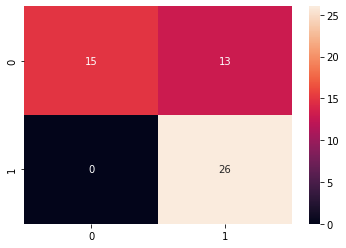

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)

sns.heatmap(cm, annot=True)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        28
           1       0.67      1.00      0.80        26

    accuracy                           0.76        54
   macro avg       0.83      0.77      0.75        54
weighted avg       0.84      0.76      0.75        54



**Fine tunning**

Complementa ao aprendizado por transferência.

Fine tunning -> treinar apenas algumas camadas da rede pré-treinada e então retreiná-los. Ajustar também os pesos das camadas mais próximas das camadas densas.

In [37]:
# Selecionado algumas camadas e deixa ro parâmetro Trainable = True, para indicar que essas camadas serão treinadas

modelo_base.trainable = True

In [39]:
fine_tuning_at = 140 # Camadas da rede pré-treinada que não serão retreinados
# da 140 para frente serão reteinadas
for layer in modelo_base.layers[:fine_tuning_at]:
  layer = trainable = False

In [40]:
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
historico = rede.fit(dataset_treinamento, epochs = 50)

Epoch 1/50
27/27 [==============================] - 12s 182ms/step - loss: 1.8421 - accuracy: 0.7628
Epoch 2/50
27/27 [==============================] - 4s 157ms/step - loss: 0.9459 - accuracy: 0.7116
Epoch 3/50
27/27 [==============================] - 4s 156ms/step - loss: 0.5640 - accuracy: 0.7674
Epoch 4/50
27/27 [==============================] - 4s 155ms/step - loss: 0.7274 - accuracy: 0.7442
Epoch 5/50
27/27 [==============================] - 4s 155ms/step - loss: 0.6459 - accuracy: 0.6977
Epoch 6/50
27/27 [==============================] - 4s 156ms/step - loss: 0.3812 - accuracy: 0.7907
Epoch 7/50
27/27 [==============================] - 4s 155ms/step - loss: 0.4999 - accuracy: 0.8605
Epoch 8/50
27/27 [==============================] - 7s 243ms/step - loss: 0.3636 - accuracy: 0.8419
Epoch 9/50
27/27 [==============================] - 4s 154ms/step - loss: 0.4365 - accuracy: 0.8884
Epoch 10/50
27/27 [==============================] - 5s 196ms/step - loss: 0.3498 - accuracy: 0.846

In [42]:
previsoes = rede.predict(dataset_teste)
previsoes

array([[9.9923658e-01, 7.6344429e-04],
       [9.9948347e-01, 5.1651517e-04],
       [1.0000000e+00, 2.8260468e-16],
       [1.0000000e+00, 9.6739470e-14],
       [9.9981064e-01, 1.8939174e-04],
       [9.9369437e-01, 6.3056224e-03],
       [9.8919815e-01, 1.0801898e-02],
       [1.6661407e-02, 9.8333859e-01],
       [1.0000000e+00, 3.3927362e-17],
       [6.9589931e-01, 3.0410072e-01],
       [7.0410073e-01, 2.9589930e-01],
       [9.9036562e-01, 9.6343942e-03],
       [1.7014590e-01, 8.2985413e-01],
       [9.9993968e-01, 6.0335453e-05],
       [6.8462425e-05, 9.9993157e-01],
       [9.9999976e-01, 2.2018628e-07],
       [9.9988329e-01, 1.1663627e-04],
       [5.2660191e-01, 4.7339809e-01],
       [9.9998689e-01, 1.3165673e-05],
       [1.0000000e+00, 1.9079277e-10],
       [7.6311519e-03, 9.9236888e-01],
       [9.9995792e-01, 4.2074407e-05],
       [1.0000000e+00, 1.3032353e-09],
       [8.0044314e-02, 9.1995573e-01],
       [4.7742876e-01, 5.2257121e-01],
       [9.9700528e-01, 2.

In [43]:
previsoes = np.argmax(previsoes, axis=1)
previsoes

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.8888888888888888

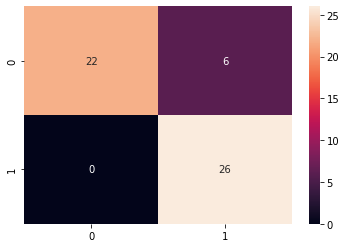

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)

sns.heatmap(cm, annot=True)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        28
           1       0.81      1.00      0.90        26

    accuracy                           0.89        54
   macro avg       0.91      0.89      0.89        54
weighted avg       0.91      0.89      0.89        54

